# SET DESIRED EVALUATION RUNS HERE

In [136]:
MODEL = 'davinci' # 'flan-t5', 'neox' or 'davinci' (temperature is set to whatever is optimal for each model)
SHOTS = 2 # 0, 1, or 2

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
import seaborn as sns
from uni_kie.pdf_to_text.pdf_to_text import SroieWrapperOwnOCR, SroieWrapper
import os
import json

In [5]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2") # this is the same tokenizer that openai uses for their instructGPT model family

In [6]:
data = pd.DataFrame(columns=["filename", "text_own_ocr", "num_tokens_own_ocr", "text_sroie_ocr", "num_tokens_sroie_ocr"])

## Extracting text with own OCR (PyMuPDF)

In [7]:
sroie_wrapper_own_ocr = SroieWrapperOwnOCR()

for i in range(len(sroie_wrapper_own_ocr.data)):
    filename = sroie_wrapper_own_ocr.data[i]
    text_own_ocr = sroie_wrapper_own_ocr.get_text(filename)
    num_tokens_own_ocr = len(tokenizer(text_own_ocr)['input_ids'])
    data = pd.concat([data, pd.DataFrame({'filename': [filename], 'text_own_ocr': [text_own_ocr], 'num_tokens_own_ocr': [num_tokens_own_ocr]})], ignore_index=True)

>>>>>>>>>>>>>> LOADING test SET


Error in pixScaleAreaMap: pixd too small
Error in pixClone: pixs not defined
Error in pixCopyText: pixd not defined
Error in pixCopyInputFormat: pixd not defined
Scaling pix of size 8, 1596 by factor 0.0225564 made null pix!!
Bad pix from ImageData!
Line cannot be recognized!!
Image too small to scale!! (1x36 vs min width of 3)
Line cannot be recognized!!
Image too small to scale!! (2x36 vs min width of 3)
Line cannot be recognized!!


KeyboardInterrupt: 

We can see that there are a lot of warnings which suggest that the OCR'd output may have issues. Let's look at an example:

In [ ]:
data.iloc[1]["filename"]

PosixPath('/Users/ivo/PycharmProjects/Levity/unimodal-kie/uni_kie/datasets/sroie/test/input/X51006619842.jpg')

<img src="/Users/ivo/PycharmProjects/Levity/unimodal-kie/uni_kie/datasets/sroie/test/input/X51006619842.jpg" width=250>

The extracted text for this receipt is:

In [ ]:
print(data.iloc[1]['text_own_ocr'])

ae.
ee
ee
Sy
i
ee te Se i
rn
pe Ae




In [ ]:
data.head()

,filename,text_own_ocr,num_tokens_own_ocr,text_sroie_ocr,num_tokens_sroie_ocr
0,/Users/ivo/PycharmProjects/Levity/unimodal-kie...,"3 \@ 02\nO14,\nLIM SENG THO HARDWARE TRADING\n...",274,NaN,NaN
1,/Users/ivo/PycharmProjects/Levity/unimodal-kie...,ae.\nee\nee\nSy\ni\nee te Se i\nrn\npe Ae\n\n,21,NaN,NaN
2,/Users/ivo/PycharmProjects/Levity/unimodal-kie...,"(481500-M)\nCW KHOO HARDWARE SDN BHD\nNO.50 , ...",330,NaN,NaN
3,/Users/ivo/PycharmProjects/Levity/unimodal-kie...,"oe\nAEON CU.\n(M) BHD (126926-H)\n+\n3RD FLR, ...",268,NaN,NaN
4,/Users/ivo/PycharmProjects/Levity/unimodal-kie...,"SANYO STATIONERY SHOP\nNO. 31G8&33G, JALAN SET...",357,NaN,NaN


In [ ]:
mean = int(np.mean(data['num_tokens_own_ocr']))
median = int(np.median(data['num_tokens_own_ocr']))
std = int(np.std(data['num_tokens_own_ocr']))
min = int(np.min(data['num_tokens_own_ocr']))
max = int(np.max(data['num_tokens_own_ocr']))

print(f"mean: {mean}, median: {median}, std: {std}, min: {min}, max: {max}")

print(f"number of documents with less than 100 tokens: {len(data[data['num_tokens_own_ocr'] < 100])}")

mean: 342, median: 335, std: 115, min: 1, max: 785
number of documents with less than 100 tokens: 12


Let's look closer at the distribution of the number of tokens.

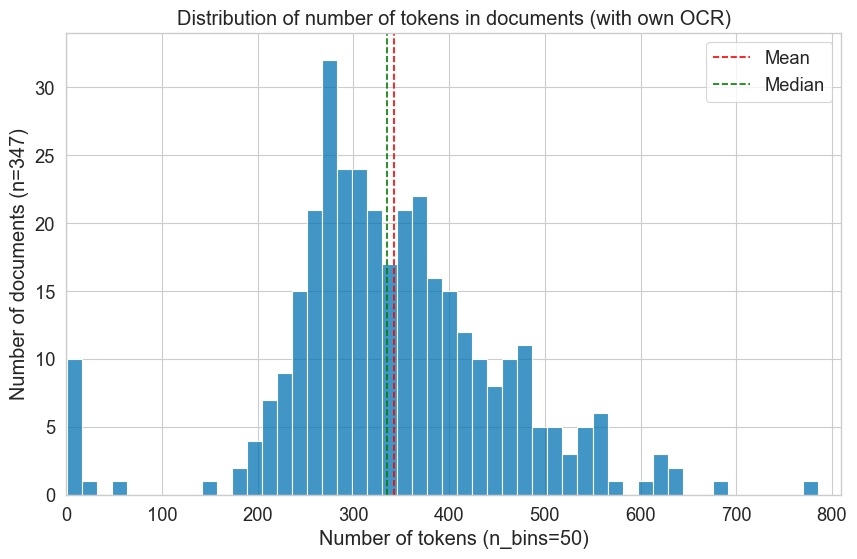

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=data, x=data["num_tokens_own_ocr"], ax=ax, bins=50)
ax.set_title("Distribution of number of tokens in documents (with own OCR)")
ax.set_xlabel(f"Number of tokens (n_bins={len(ax.patches)})")
ax.set_ylabel(f"Number of documents (n={len(data)})")
ax.axvline(data["num_tokens_own_ocr"].mean(), color="red", linestyle="--", label="Mean")
ax.axvline(data["num_tokens_own_ocr"].median(), color="green", linestyle="--", label="Median")

ax.set_xlim(0, 810)
ax.set_xticks(np.arange(0, 810, 100))

ax.set_ylim(0, 34)
ax.set_yticks(np.arange(0, 34, 5))

ax.legend()

plt.show()
fig.savefig("plots/sroie/token_distribution_own_ocr.png", dpi=300, bbox_inches="tight")

Let's look at the shortest document to get a better idea of what the input text looks like.

In [ ]:
# find the shortest document
data[data['num_tokens_own_ocr'] == data['num_tokens_own_ocr'].min()]

# print the text of the shortest document
print(data[data['num_tokens_own_ocr'] == data['num_tokens_own_ocr'].min()]['text_own_ocr'].values[0])

We don't even have any text for this particular receipt.

Let's check if the text of the receipts fits in our models

In [ ]:
print(f"The longest document has {data['num_tokens_own_ocr'].max()} tokens")

The longest document has 785 tokens


Great news, even the longest doc will easily fit into our smaller GPT-NeoX and Flan-T5 models (limit 1792).

Nonetheless, 12 out of the 347 documents basically don't have any extracted text. Motivated by this and the fact that potential future work should be comparable to ours, we will use the provided OCR by the data set.

## Using provided OCR

In [8]:
sroie_wrapper = SroieWrapper()

for i in range(len(sroie_wrapper.data)):
    filename = sroie_wrapper.data.iloc[i]['filename']
    text_sroie_ocr = sroie_wrapper.get_text(filename)
    num_tokens_sroie_ocr = len(tokenizer(text_sroie_ocr)['input_ids'])

    data.loc[data['filename'] == filename, 'text_sroie_ocr'] = text_sroie_ocr
    data.loc[data['filename'] == filename, 'num_tokens_sroie_ocr'] = num_tokens_sroie_ocr

>>>>>>>>>>>>>> LOADING test SET


In [9]:
data.head()

,filename,text_own_ocr,num_tokens_own_ocr,text_sroie_ocr,num_tokens_sroie_ocr
0,/Users/ivo/PycharmProjects/Levity/unimodal-kie...,"3 \@ 02\nO14,\nLIM SENG THO HARDWARE TRADING\n...",274,LIM SENG THO HARDWARE TRADING\nNO 7. SIMPANG O...,267
1,/Users/ivo/PycharmProjects/Levity/unimodal-kie...,ae.\nee\nee\nSy\ni\nee te Se i\nrn\npe Ae\n\n,21,"YIN MA (M) SDN.BHD.(974306-T)\nNO.2, JALAN UDA...",285
2,/Users/ivo/PycharmProjects/Levity/unimodal-kie...,"(481500-M)\nCW KHOO HARDWARE SDN BHD\nNO.50 , ...",330,"(481500-M)\nC W KHOO HARDWARE SDN BHD\nNO.50 ,...",333
3,/Users/ivo/PycharmProjects/Levity/unimodal-kie...,"oe\nAEON CU.\n(M) BHD (126926-H)\n+\n3RD FLR, ...",268,"AEON CO. (M) BHD (126926-H)\n3RD FLR, AEON TAM...",272


In [10]:
mean = int(np.mean(data['num_tokens_sroie_ocr']))
median = int(np.median(data['num_tokens_sroie_ocr']))
std = int(np.std(data['num_tokens_sroie_ocr']))
min = int(np.min(data['num_tokens_sroie_ocr']))
max = int(np.max(data['num_tokens_sroie_ocr']))

print(f"mean: {mean}, median: {median}, std: {std}, min: {min}, max: {max}")

print(f"number of documents with less than 100 tokens: {len(data[data['num_tokens_sroie_ocr'] < 100])}")

mean: 289, median: 278, std: 26, min: 267, max: 333
number of documents with less than 100 tokens: 0


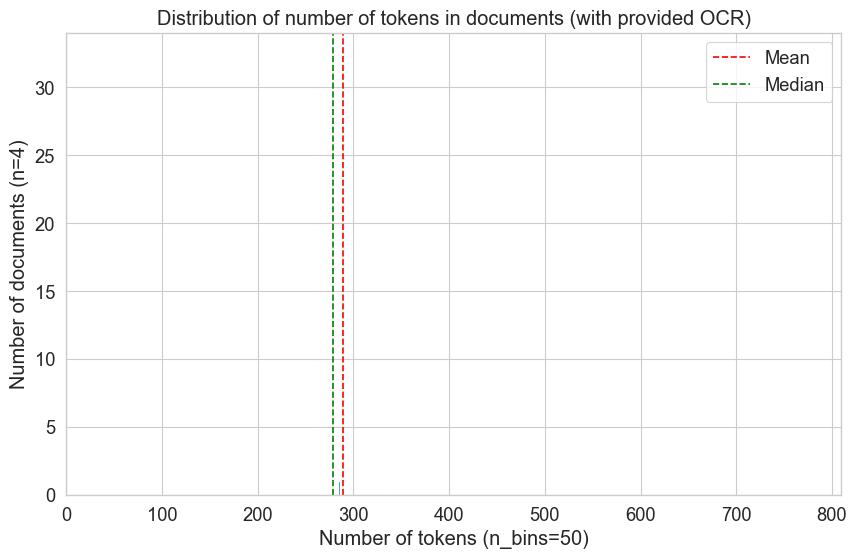

In [11]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=data, x=data["num_tokens_sroie_ocr"], ax=ax, bins=50)
ax.set_title("Distribution of number of tokens in documents (with provided OCR)")
ax.set_xlabel(f"Number of tokens (n_bins={len(ax.patches)})")
ax.set_ylabel(f"Number of documents (n={len(data)})")
ax.axvline(data["num_tokens_sroie_ocr"].mean(), color="red", linestyle="--", label="Mean")
ax.axvline(data["num_tokens_sroie_ocr"].median(), color="green", linestyle="--", label="Median")

ax.set_xlim(0, 810)
ax.set_xticks(np.arange(0, 810, 100))

ax.set_ylim(0, 34)
ax.set_yticks(np.arange(0, 34, 5))

ax.legend()

plt.show()
fig.savefig("plots/sroie/token_distribution_sroie_ocr.png", dpi=300, bbox_inches="tight")

In [12]:
# let's look at the text of the shortest document
print(data[data['num_tokens_sroie_ocr'] == data['num_tokens_sroie_ocr'].min()]['text_sroie_ocr'].values[0])

LIM SENG THO HARDWARE TRADING
NO 7. SIMPANG OFF BATU VILLAGE,
JALAN IPOH BATU 5, 51200 KUATA LUMPUR
MALAYSIA
TEL & FAX NO: 03-6258 7191
03-6258 7191
COMPAN, REG NO. (002231061-T)
GST REG NO. 001269075968
TAX INVOICE
INVOICE NO
CS 24146
DATE:
02/02/2018 10:06
CASMER #
LST
RM
CODE
BEG GUNI
10.00 NOS
X
0.70
7.00
SR
SUBTOTAL:
7.00
TOTAL INCL. OF GST
7.00
PAYMENT:
7.00
CHANGE DUE:
0.00
TOTAL ITEM(S): 10
GST SUMMARY
AMOUNT(RM)
TAX(RM)
SR
@ 6%
6.60
0.40
THANK YOU
PLEASE COME AGAIN
*GOODS SOLD ARE NOT RETURNABLE*


In [13]:
print(f"The longest document has {data['num_tokens_sroie_ocr'].max()} tokens")

The longest document has 333 tokens


## Exploring whether all keys are given in the gold standard (Loading Gold)

In [14]:
path_to_sroie = "./datasets/sroie/test/"

In [15]:
path_to_gold_standard = path_to_sroie + "gold/"

keys = ["company", "date", "address", "total"]

gold_standard = {}
for filename in os.listdir(path_to_gold_standard):
    with open(os.path.join(path_to_gold_standard, filename), 'r') as f:
        gold_standard[filename] = json.load(f)

for filename, file in gold_standard.items():
    for key in keys:
        if key not in file:
            print(f"{key} is not in {filename}")
        elif file[key] == "":
            print(f"{key} in {filename} is an empty string")

In [23]:
# load into a dataframe
gold_standard_df = pd.DataFrame.from_dict(gold_standard, orient='index')

In [137]:

if MODEL == 'flan-t5':
    if SHOTS == 0:
        PREDICTION_RUNS_PATHS = [
            path_to_sroie + 'predictions/flan-t5/2023-01-25T21-26-54_LLMPipeline(prompt_variant=NeutralPrompt, model=Flan_T5(max_input_tokens=1792, temperature=0, top_p=0.9, top_k=40), parser=DictParser, shots=False)',
            path_to_sroie + 'predictions/flan-t5/2023-01-25T21-26-56_LLMPipeline(prompt_variant=NeutralPrompt, model=Flan_T5(max_input_tokens=1792, temperature=0, top_p=0.9, top_k=40), parser=DictParser, shots=False)',
            path_to_sroie + 'predictions/flan-t5/2023-01-25T21-29-59_LLMPipeline(prompt_variant=NeutralPrompt, model=Flan_T5(max_input_tokens=1792, temperature=0, top_p=0.9, top_k=40), parser=DictParser, shots=False)',
        ]

    elif SHOTS == 1:
        PREDICTION_RUNS_PATHS = [
            path_to_sroie + 'predictions/flan-t5/2023-01-25T21-33-13_LLMPipeline(prompt_variant=NeutralPrompt, model=Flan_T5(max_input_tokens=1792, temperature=0, top_p=0.9, top_k=40), parser=DictParser, shots=True)',
            path_to_sroie + 'predictions/flan-t5/2023-01-25T21-33-17_LLMPipeline(prompt_variant=NeutralPrompt, model=Flan_T5(max_input_tokens=1792, temperature=0, top_p=0.9, top_k=40), parser=DictParser, shots=True)',
            path_to_sroie + 'predictions/flan-t5/2023-01-25T21-35-11_LLMPipeline(prompt_variant=NeutralPrompt, model=Flan_T5(max_input_tokens=1792, temperature=0, top_p=0.9, top_k=40), parser=DictParser, shots=True)',
        ]

    elif SHOTS == 2:
        PREDICTION_RUNS_PATHS = [
            path_to_sroie + 'predictions/flan-t5/2023-01-25T22-00-26_LLMPipeline(prompt_variant=NeutralPrompt, model=Flan_T5(max_input_tokens=1792, temperature=0, top_p=0.9, top_k=40), parser=DictParser, shots=TWOSHOT)',
            path_to_sroie + 'predictions/flan-t5/2023-01-25T22-00-28_LLMPipeline(prompt_variant=NeutralPrompt, model=Flan_T5(max_input_tokens=1792, temperature=0, top_p=0.9, top_k=40), parser=DictParser, shots=TWOSHOT)',
            path_to_sroie + 'predictions/flan-t5/2023-01-25T22-00-33_LLMPipeline(prompt_variant=NeutralPrompt, model=Flan_T5(max_input_tokens=1792, temperature=0, top_p=0.9, top_k=40), parser=DictParser, shots=TWOSHOT)',
        ]

elif MODEL == 'neox':
    if SHOTS == 0:
        PREDICTION_RUNS_PATHS = [
            path_to_sroie + 'predictions/neox/2023-01-25T19-27-04_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=False)',
            path_to_sroie + 'predictions/neox/2023-01-25T19-28-11_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=False)',
            path_to_sroie + 'predictions/neox/2023-01-25T19-28-15_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=False)',
        ]

    elif SHOTS == 1:
        PREDICTION_RUNS_PATHS = [
            path_to_sroie + 'predictions/neox/2023-01-25T22-17-14_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=True)',
            path_to_sroie + 'predictions/neox/2023-01-25T22-17-15_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=True)',
            path_to_sroie + 'predictions/neox/2023-01-25T22-17-18_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=True)',
        ]

    elif SHOTS == 2:
        PREDICTION_RUNS_PATHS = [
            path_to_sroie + 'predictions/neox/2023-01-25T22-18-33_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=TWOSHOT)',
            path_to_sroie + 'predictions/neox/2023-01-25T22-18-36_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=TWOSHOT)',
            path_to_sroie + 'predictions/neox/2023-01-25T22-18-39_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT_NeoX(max_input_tokens=1792, temperature=1, top_p=0.9, top_k=40, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=TWOSHOT)',
        ]

elif MODEL == 'davinci':
    if SHOTS == 0:
        PREDICTION_RUNS_PATHS = [
            path_to_sroie + 'predictions/davinci/2023-01-26T18-29-10_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0.1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=False)',
            path_to_sroie + 'predictions/davinci/2023-01-26T19-02-22_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0.1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=False)',
            path_to_sroie + 'predictions/davinci/2023-01-27T12-22-26_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0.1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=False)',
        ]

    elif SHOTS == 1:
        PREDICTION_RUNS_PATHS = [
            path_to_sroie + 'predictions/davinci/2023-01-27T12-22-44_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0.1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=True)',
            path_to_sroie + 'predictions/davinci/2023-01-27T12-22-46_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0.1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=True)',
            path_to_sroie + 'predictions/davinci/2023-01-27T12-22-48_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0.1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=True)',
        ]

    elif SHOTS == 2:
        PREDICTION_RUNS_PATHS = [
            path_to_sroie + 'predictions/davinci/2023-01-27T12-23-09_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0.1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=TWOSHOT)',
            path_to_sroie + 'predictions/davinci/2023-01-27T12-23-11_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0.1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=TWOSHOT)',
            path_to_sroie + 'predictions/davinci/2023-01-27T12-23-13_LLMPipeline(prompt_variant=NeutralPrompt, model=GPT3_Davinci(max_input_tokens=3840, temperature=0.1, top_p=0.9, presence_penalty=0, frequency_penalty=0), parser=DictParser, shots=TWOSHOT)',
        ]


In [138]:
predictions_runs_dfs = []
for path in PREDICTION_RUNS_PATHS:
    predictions_run = {}
    for filename in os.listdir(path):
        with open(os.path.join(path, filename), 'r') as f:
            predictions_run[filename] = json.load(f)


    predictions_run_df = pd.DataFrame.from_dict(predictions_run, orient='index')
    predictions_run_df = predictions_run_df.reindex(columns=gold_standard_df.columns, fill_value=np.nan)
    predictions_runs_dfs.append(predictions_run_df)


In [139]:
predictions_runs_dfs[0].head()

,company,date,address,total
X51005675104.txt,SYARIKAT PERNIAGAAN GIN KEE,25/01/2018,"NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA...",190.80
X51005568890.txt,HON HWA HARDWARE TRADING,05/01/2017,"NO 37, JALAN MANIS 7, TAMAN SEGAR, 56100 CHERA...",5.00
X00016469670.txt,OJC MARKETING SDN BHD,15/01/2019,"NO 2 & 4, JALAN BAYU 4, BANDAR SERI ALAM, 8175...",193.00
X51006557507.txt,GARDENIA BAKERIES (KL) SDN BHD,27/10/2017,"LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SE...",35.88
X51007846396.txt,GERBANG ALAF RESTAURANTS SDN BHD,24/06/2018,"LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3, NO.3,...",7.35


In [140]:
# create evaluation dataframe per run
eval_dfs = []
for predictions_run_df in predictions_runs_dfs:
    eval_df = pd.DataFrame()
    # iterate over the rows (the documents) of the predictions dataframe
    for index, row in predictions_run_df.iterrows():
        # check for each column (the keys) if the prediction is correct
        for key in keys:
            # if the prediction is correct, the value is 1
            if row[key] == gold_standard_df.loc[index][key]:
                eval_df.loc[index, key] = 1
            # if the prediction is incorrect, the value is 0
            else:
                eval_df.loc[index, key] = 0

    # as we only check the documents for which we have predicted at least one key, we need to add the documents for which we have not predicted any key as 0 for all keys
    for index, row in gold_standard_df.iterrows():
        if index not in eval_df.index:
            eval_df.loc[index] = 0

    eval_dfs.append(eval_df)

In [141]:
# what is the overall accuracy of the model (averaged over the runs with min max and mean)
accuracy_by_key = []
overall_accuracy = []
for eval_df in eval_dfs:
    accuracy_by_key.append(eval_df.mean())
    overall_accuracy.append(eval_df.mean().mean())

# print the accuracy per key
for key in keys:
    print(f"Accuracy for {key}: {np.mean([accuracy_by_key[i][key] for i in range(len(accuracy_by_key))])} (min: {np.min([accuracy_by_key[i][key] for i in range(len(accuracy_by_key))])}, max: {np.max([accuracy_by_key[i][key] for i in range(len(accuracy_by_key))])})")
print(f"Overall accuracy: {np.mean(overall_accuracy)} (min: {np.min(overall_accuracy)}, max: {np.max(overall_accuracy)})")


Accuracy for company: 0.9212295869356387 (min: 0.9193083573487032, max: 0.9221902017291066)
Accuracy for date: 0.9058597502401536 (min: 0.9020172910662824, max: 0.9106628242074928)
Accuracy for address: 0.5513928914505284 (min: 0.5446685878962536, max: 0.5590778097982709)
Accuracy for total: 0.7406340057636888 (min: 0.7406340057636888, max: 0.7406340057636888)
Overall accuracy: 0.7797790585975024 (min: 0.7788184438040345, max: 0.7809798270893372)
